In [1]:
%load_ext autoreload
%autoreload 2

from evaluation_scripts.base import load_json, get_base_pathes
import os
from evaluation_scripts.base import load_pickle_obj
from model_scripts.sensitivity_evaluation import SensitivityAnalysis, summarize_evaluations, count_strategy, get_shared, collect_stats
from model_scripts.wins_and_losses import WinsAndLosses, set_title, set_common_ylabel
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd


_, base = get_base_pathes()
path = os.path.join(base, "sensitivity_sim")

name_add = "_preexisting"

In [2]:
sensitivity = SensitivityAnalysis(path, parameter_names = ["turnover",
                                "infection", "cA", "cB", "cS", "cU", "cAB"], name_add = name_add)
reload = True
if reload:
    sensitivity.load()
else:
    sims = pd.read_pickle(os.path.join(path, "sensitivity_sim"+name_add+".pkl"))
    pars = pd.read_pickle(os.path.join(path, "sensitivity_par"+name_add+".pkl"))
    sensitivity.evaluate_parameter_sets(sims, pars)
    sensitivity.save()

In [3]:
df = summarize_evaluations(sensitivity.evaluations)


results = []
for strategy in ["Combination", "Cycling", "Mixing", "Mono A", "Mono B"]:
    results.append(count_strategy(df, strategy))
results = pd.DataFrame().from_records(results)
results = results.set_index("strategy")

insignificant = df.apply(lambda x: get_shared(x, "worst_", None), axis = 1).sum()

print("Num of insignificant scenarios: ", insignificant)

results

Num of insignificant scenarios:  606


,single_winner,single_loser,loser,winner
strategy,,,,
Combination,5487,0,95,8676
Cycling,9,6,1210,2332
Mixing,40,2,1478,2054
Mono A,365,2359,4857,1749
Mono B,0,4250,6229,811


In [4]:
results_rel = results.copy()
results_rel = results_rel * 100 / len(sensitivity.evaluations)
results_rel

,single_winner,single_loser,loser,winner
strategy,,,,
Combination,54.87,0.00,0.95,86.76
Cycling,0.09,0.06,12.10,23.32
Mixing,0.40,0.02,14.78,20.54
Mono A,3.65,23.59,48.57,17.49
Mono B,0.00,42.50,62.29,8.11


In [5]:
color_1 = ["#FFA500", "#FF8C00", "#FF6347"]
color_2 = ["#00CED1", "#40E0D0", "#20B2AA"]
colors = {
    "single_win":"#5779B7", 
    "total_win":"#8DACD6",
    "single_loss":"#B74A4A", 
    "total_loss":"#D68A8A",
}

file_path = os.path.join(base, "summary", "exp_anova_no_notreat.json")
exp_results = load_json(file_path)
exp_results = [exp_results[0], exp_results[2]]

/Users/malte/ETH-Documents/TSP-Collection/TSPlasmids_main/JupyterScripts/model_scripts/wins_and_losses.py:219: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(int(label)) for label in ax.get_yticks()])


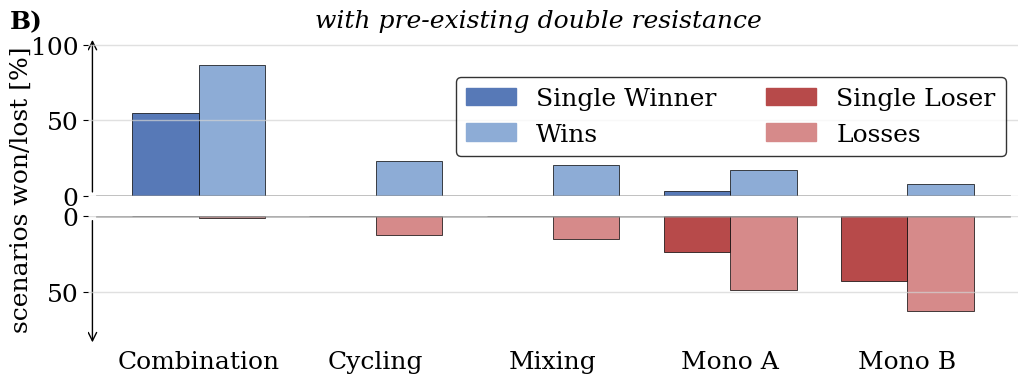

In [6]:
fontsize = 18
from figures import Figure, styles
figure = Figure(styles["paper"])

WandL = WinsAndLosses(results_rel, path, colors, fontsize=fontsize, axes_label_fontsize=fontsize, y_label_x = -.1, figsize=(12, 4))
#WandL.add_exp_results(exp_results)
fig, axs = WandL.plot(title = None, legend = True, hspace = .14)
set_title(fig, "B)", "with pre-existing double resistance", title_y = .95, family = "serif", fontsize = fontsize)
set_common_ylabel(fig, axs, "scenarios won/lost [%]", fontsize = fontsize)
for ax in axs:
    figure.format_labels(ax, fontsize= fontsize)
    figure.format_ticks(ax, fontsize= fontsize)
    figure.format_legend(ax, fontsize= fontsize)
    figure.format_annotations(ax, fontsize= fontsize)
WandL.save(path, name_add = name_add)


In [7]:
results_df = results_rel.copy()
results_df = results_df.rename(columns=lambda x: x + " [\%]")
results_df = results_df.join(results)
results_df.columns = [col.replace('_', ' ') for col in results_df.columns]
results_df.to_latex(os.path.join(base, "tables", "win_loss_statistic"+name_add+".tex"),
                   float_format="%.2f")
results_df

,single winner [\%],single loser [\%],loser [\%],winner [\%],single winner,single loser,loser,winner
strategy,,,,,,,,
Combination,54.87,0.00,0.95,86.76,5487,0,95,8676
Cycling,0.09,0.06,12.10,23.32,9,6,1210,2332
Mixing,0.40,0.02,14.78,20.54,40,2,1478,2054
Mono A,3.65,23.59,48.57,17.49,365,2359,4857,1749
Mono B,0.00,42.50,62.29,8.11,0,4250,6229,811


In [8]:
insignificant

606

In [9]:
worst_stats = collect_stats(df, "worst")
worst_stats.columns = [col.replace('_', '\_') for col in worst_stats.columns]
best_stats = collect_stats(df, "best")
best_stats.columns = [col.replace('_', '\_') for col in best_stats.columns]
worst_stats.to_latex(os.path.join(base, "tables", "worst_stats"+name_add+".tex"),
                   float_format="%.2f")
best_stats.to_latex(os.path.join(base, "tables", "best_stats"+name_add+".tex"),
                   float_format="%.2f")
display(worst_stats)
display(best_stats)

,turnover,infection,U,S,A\_r,B\_r,AB\_r,n
Mono B,0.570205,0.463901,0.214866,0.194165,0.131466,0.275346,0.184158,4250.0
Mono A,0.510445,0.433976,0.226070,0.191560,0.302264,0.098215,0.181891,2359.0
Cycling,0.420000,0.720000,0.231667,0.208333,0.143333,0.140000,0.276667,6.0
Mixing,0.340000,0.710000,0.230000,0.200000,0.185000,0.090000,0.295000,2.0


,turnover,infection,U,S,A\_r,B\_r,AB\_r,n
Combination,0.606709,0.469397,0.210980,0.182710,0.216492,0.222242,0.167576,5487.0
Mono A,0.523836,0.557233,0.232082,0.199123,0.157918,0.146137,0.264740,365.0
Mixing,0.133000,0.300250,0.234500,0.211500,0.178000,0.153000,0.223000,40.0
Cycling,0.135556,0.201111,0.228889,0.200000,0.210000,0.204444,0.156667,9.0
